## Accessing and Analyzing High Resolution Rapid Refresh (HRRR) Data

The High Resolution Rapid Refresh (HRRR, pronouned "her") is NOAA real-time 3-km resolution, hourly updated, cloud-resolving, convection-allowing atmospheric model, initialized by 3km grids with 3km radar assimilation. Radar data is assimilated in the HRRR every 15 min over a 1-h period adding further detail to that provided by the hourly data assimilation from the 13km radar-enhanced Rapid Refresh. HRRR data is available on AWS Open Data Registry via NOAA's Big Data Program. More information about HRRR data on AWS can be found at https://registry.opendata.aws/noaa-hrrr-pds/.

The HRRR data is available as its native data format or as zarr format which is managed by MesoWest. This tutorial is build upon examples using HRRR zarr files on AWS.

More information about zarr format HRRR data can be found on [Mesowest](https://mesowest.utah.edu/html/hrrr/) page.

### Chunk Access of HRRR data from AWS

The zarr HRRR file is stored in chunks for the entire continental United States area as shown below.

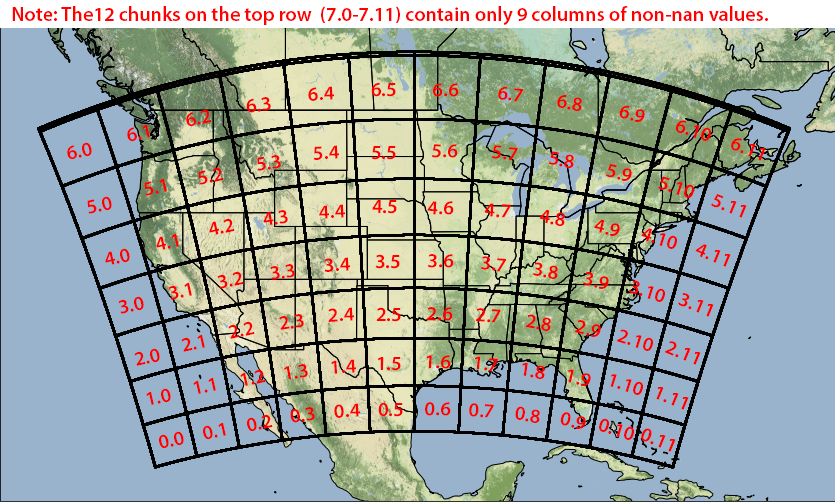

We can directly access and decompress a chunk of data rather than the entire model run.

In [2]:
import s3fs
import numcodecs as ncd
import numpy as np

In [3]:
def retrieve_data(s3_url):
    with s3.open(s3_url, 'rb') as compressed_data:
        buffer = ncd.blosc.decompress(compressed_data.read())

        dtype = "<f2"
        if ("surface/PRES" in s3_url
            or "mean_sea_level/MSLMA" in s3_url
            or "0C_isotherm/PRES" in s3_url): # Pressures above 1000hPa use a larger data type
            dtype = "<f4"

        chunk = np.frombuffer(buffer, dtype=dtype)
        
        gridpoints_in_chunk = 150*150
        number_hours = len(chunk)//gridpoints_in_chunk

        if number_hours == 1: # analysis data is 2d
            data_array = np.reshape(chunk, (150, 150))
        else: # forecast data is 3d but of varying length in time
            data_array = np.reshape(chunk, (number_hours, 150, 150))

    return data_array

In [11]:
url = "s3://hrrrzarr/sfc/20211201/20211201_00z_anl.zarr/1000mb/TMP/1000mb/TMP/4.3"
s3 = s3fs.S3FileSystem(anon=True)

chunk_data = retrieve_data(url)
chunk_data.shape
#print(np.mean(chunk_data))

(150, 150)

### Access HRRR data from AWS via Zarr library

Previous code use the basic way to load one chunk as numpy array. As this data is store in zarr, we can directly access the data via zarr library.

In [8]:
import zarr

url = "s3://hrrrzarr"
fs = s3fs.S3FileSystem(anon=True)
store = zarr.open(s3fs.S3Map(url, s3=fs))

Although we opened the file, we still have not read in any data yet. Let's look for a specific variable from the zarr data store.

In [12]:
temperature = store["sfc/20211201/20211201_00z_anl.zarr/1000mb/TMP/1000mb/TMP"]
index = store["grid/HRRR_chunk_index.zarr"]

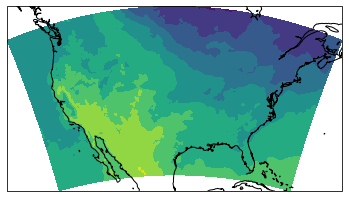

In [13]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.Mercator())
ax.contourf(index["longitude"], index["latitude"], temperature, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

### Access HRRR data from AWS - xarray

Except being opened via zarr libary, it can also be directly accessed via `xarray`.

In [14]:
import xarray as xr
import metpy

In [15]:
group_url = 's3://hrrrzarr/sfc/20211201/20211201_00z_anl.zarr/surface/GUST'
subgroup_url = f"{group_url}/surface"

fs = s3fs.S3FileSystem(anon=True)    
ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in [group_url, subgroup_url]], engine='zarr')

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                   globe=ccrs.Globe(semimajor_axis=6371229,
                                                    semiminor_axis=6371229))

ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
ds = ds.metpy.assign_crs(projection.to_cf())
ds = ds.metpy.assign_latitude_longitude()    
ds

<xarray.Dataset>
Dimensions:                  (x: 1799, y: 1059)
Coordinates:
  * x                        (x) float64 -2.698e+06 -2.695e+06 ... 2.696e+06
  * y                        (y) float64 -1.587e+06 -1.584e+06 ... 1.587e+06
    metpy_crs                object Projection: lambert_conformal_conic
    latitude                 (y, x) float64 21.14 21.15 21.15 ... 47.85 47.84
    longitude                (y, x) float64 -122.7 -122.7 ... -60.95 -60.92
Data variables:
    GUST                     (y, x) float16 dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    height                   float64 ...
    pressure                 float64 ...
    time                     datetime64[ns] ...

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


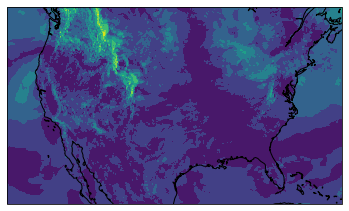

In [17]:
ax = plt.axes(projection=projection)
ax.contourf(ds.x, ds.y, ds.GUST)
ax.coastlines()
plt.show()

### Accessing Multiple Variables - Zarr API vs xarray

Because the HRRR zarr data is stored using zarr groups, xarray isn't always the most convenient method for accessing the data. Here, we look at how to use the zarr API to load a whole group, which lets us access multiple variables easily and efficiently.

In [20]:
%%time

url = "s3://hrrrzarr/sfc/20211201/20211201_00z_anl.zarr"
fs = s3fs.S3FileSystem(anon=True)
store = zarr.open(s3fs.S3Map(url, s3=fs))

CPU times: user 27.6 ms, sys: 0 ns, total: 27.6 ms
Wall time: 1.11 s


In [21]:
%%time
thousand_mb_tmp = store["1000mb/TMP/1000mb/TMP"]
surface_tmp = store["surface/TMP/surface/TMP"]
hcdc = store["high_cloud_layer/HCDC/high_cloud_layer/HCDC"]
rh = store["2m_above_ground/RH/2m_above_ground/RH"]
spfh = store["2m_above_ground/SPFH/2m_above_ground/SPFH"]
dpt = store["2m_above_ground/DPT/2m_above_ground/DPT"]
pot = store["2m_above_ground/POT/2m_above_ground/POT"]
tmp = store["2m_above_ground/TMP/2m_above_ground/TMP"]

CPU times: user 62.1 ms, sys: 9.61 ms, total: 71.7 ms
Wall time: 2.03 s


As you can see, it takes about 2 seconds to open 8 variables. This is pretty fast, but not all the data has actually been downloaded or loaded into memory, so there may be about another second added on to any calculation where you actually access the data .

In [22]:
%%time
surface_tmp[...] # load into memory

CPU times: user 246 ms, sys: 19.6 ms, total: 266 ms
Wall time: 1.34 s


array([[296. , 296. , 296. , ..., 301.2, 301.2, 301.2],
       [296. , 296. , 296. , ..., 301.2, 301.2, 301.2],
       [296. , 296. , 296. , ..., 301.2, 301.2, 301.2],
       ...,
       [282.8, 282.8, 282.8, ..., 278.8, 278.8, 278.8],
       [282.8, 282.8, 282.8, ..., 278.8, 278.8, 278.8],
       [282.8, 282.8, 282.8, ..., 278.5, 278.8, 278.8]], dtype=float16)

If we load the chunk index, we can plot the variables by lat/lon.

In [23]:
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))
chunk_index

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Coordinates:
  * x           (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y           (y) float64 -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
Data variables:
    chunk_id    (x, y) object dask.array<chunksize=(225, 265), meta=np.ndarray>
    chunk_x     (x) int32 dask.array<chunksize=(1799,), meta=np.ndarray>
    chunk_y     (y) int32 dask.array<chunksize=(1059,), meta=np.ndarray>
    in_chunk_x  (x) int32 dask.array<chunksize=(1799,), meta=np.ndarray>
    in_chunk_y  (y) int32 dask.array<chunksize=(1059,), meta=np.ndarray>
    index_x     (x) int32 dask.array<chunksize=(1799,), meta=np.ndarray>
    index_y     (y) int32 dask.array<chunksize=(1059,), meta=np.ndarray>
    latitude    (y, x) float64 dask.array<chunksize=(133, 450), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(133, 450), meta=np.ndarray>

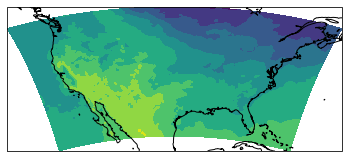

In [24]:
## Surface temperature 2021-12-01
ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(chunk_index.longitude, chunk_index.latitude, surface_tmp)
ax.coastlines()

plt.show()
plt.close()

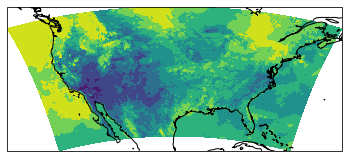

In [25]:
## Relative humidity 2021-12-01
ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(chunk_index.longitude, chunk_index.latitude, rh)
ax.coastlines()

plt.show()
plt.close()

### Plotting HRRR Zarr data for a single gridpoint

For a (lat, lon) point, find out how to index into the hrrr zarr array to get the closest gridpoint
For that gridpoint and a given time, plot the forecast temperature using the hrrr zarr data on AWS
For the same (lat,lon) point grab the analysis files for that previous forecast period to verify the forecast. 

Feel free to change the following variables for your use case!

* lat & lon coordinates: For the desired point location
* Date & time of model run: The start of the forecast period
* level: surface, 700mb, or top_of_atmosphere, etc...
* variable: TMP (temperature), PRES (pressure), or HGT (height), etc...

For a complete list of levels and variables go here.

In [33]:
### Finding the nearest point for New Orleans Convention Center (29.9375 N, 90.0619 W).
### Can only do coordinates in area that is covered by the HRRR CONUS grid.

point_lat = 29.9375
point_lon = -90.0619

# Date: [YYYYMMDD] must be in this format. Example is for Dec 10, 2021
date = '20211210'

# Hour: [00-23]z must be in the two digit format  i.e. 06 or 19
hr = '00'

# Level: 
level = 'surface'

# Variable:
var = 'TMP'

data_url = f'hrrrzarr/sfc/{date}/{date}_{hr}z_fcst.zarr/{level}/{var}/{level}/{var}/'

In [34]:
fs = s3fs.S3FileSystem(anon=True)

### Part 1 - Find our gridpoint

In order to grab data at just one gridpoint, we download a single "chunk" of the zarr array. To find which chunk that should be, we need to look up our latitude and longitude in a chunk index file provided for this purpose.

In [35]:
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))

Since the latitude and longitude we have don't correspond to an exact gridpoint location, we need to look up the nearest gridpoint. To do that, we first need to translate the latitude and longitude into the grid's native projection.

In [36]:
# This is the projection the HRRR grid uses.
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                   globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

x, y = projection.transform_point(point_lon, point_lat, ccrs.PlateCarree())

nearest_point = chunk_index.sel(x=x, y=y, method="nearest")
fcst_chunk_id = f"0.{nearest_point.chunk_id.values}"
print(fcst_chunk_id)

0.1.7


Note that for forecast files, we need to prepend "0." to the chunk ID (because forecast files have 3 dimensions, time as well as the x and y coordinates), but for analysis files, the chunk id that comes from the file is complete.

### Part 2 - Download and plot a timeseries from forecast data
Now that we know the right chunk, we can grab the data from AWS using *boto3* and decompress it using </numcodecs/>.

In [37]:
%%time
def retrieve_data(s3_url):
    with fs.open(s3_url, 'rb') as compressed_data: # using s3fs
        buffer = ncd.blosc.decompress(compressed_data.read())

        dtype = "<f2"
        if "surface/PRES" in s3_url: # surface/PRES is the only variable with a larger data type
            dtype = "<f4"

        chunk = np.frombuffer(buffer, dtype=dtype)
        
        entry_size = 150*150
        num_entries = len(chunk)//entry_size

        if num_entries == 1: # analysis file is 2d
            data_array = np.reshape(chunk, (150, 150))
        else:
            data_array = np.reshape(chunk, (num_entries, 150, 150))

    return data_array


data = retrieve_data(data_url + fcst_chunk_id)
print(data.shape)

(48, 150, 150)
CPU times: user 14.9 ms, sys: 8.37 ms, total: 23.3 ms
Wall time: 717 ms


This downloaded the entire 150x150 gridpoint chunk, for all 48 forecast hours. Now let's get to the data just for our gridpoint.



In [38]:
gridpoint_forecast = data[:, nearest_point.in_chunk_x, nearest_point.in_chunk_y]

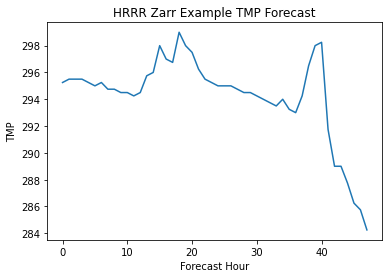

In [39]:
plt.title('HRRR Zarr Example %s Forecast' %(var))
plt.xlabel('Forecast Hour')
plt.ylabel(var)
plt.plot(gridpoint_forecast)

### Part 3 - Download and plot analysis data to verify the forecast
Now, let's check how accurate the forecast was - and in the process learn how to download analysis files.

We need to download 48 files this time - one for every forecast hour. We'll use the datetime module to help us iterate through the hours.



In [41]:
%%time
anl_chunk_id = nearest_point.chunk_id.values # doesn't have the 0.

start = datetime.datetime.strptime(date + hr, '%Y%m%d%H')
forecast_length = len(gridpoint_forecast)
gridpoint_analysis = []

for time_delta in range(forecast_length):
    # construct the aws path
    analysis_time = start + datetime.timedelta(hours=time_delta)
    url = analysis_time.strftime(f'hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{var}/{level}/{var}/{anl_chunk_id}')
    
    # download the chunk from s3
    hrrr_data_anl = retrieve_data(url)
    
    # append the data we need
    gridpoint_analysis.append(hrrr_data_anl[nearest_point.in_chunk_x, nearest_point.in_chunk_y])

CPU times: user 806 ms, sys: 37.6 ms, total: 844 ms
Wall time: 16.7 s


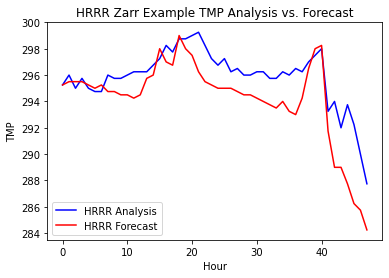

In [42]:
plt.title('HRRR Zarr Example %s Analysis vs. Forecast' %(var))
plt.xlabel('Hour')
plt.ylabel(var)
plt.plot(gridpoint_analysis, color='blue', label='HRRR Analysis')
plt.plot(gridpoint_forecast, color='red', label='HRRR Forecast')
plt.legend()

### Download an analysis variable, whole grid, 24 hours
This example shows how to get a day's worth of analysis files for a single variable and combine them using high-level APIs.

We use xarray's `open_mfdataset` to load the data. There's a couple things missing from the metadata, so we use a metpy extension to add projection info and latitude/longitude. We also promote the "time" attribute to a coordinate so that combining the datasets for each hour will work later on.

In [43]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    ds = ds.set_coords("time")
    return ds

The following function demonstrates how to format the urls to load the data, as well as how to combine the hours using `xarray.concat`. Note that because there's an extra level of nesting for the main data variable (level and variable name), we have to get both the zarr group url and the url for the nested subgroup. That's why we have to use `open_mfdataset` ("mf" means "multifile")––other zarr datasets likely won't have this quirk.

In [44]:
def load_combined_dataset(start_date, num_hours, level, param_short_name):
    combined_ds = None
    for i in range(num_hours):
        time = start_date + datetime.timedelta(hours=i)
        group_url = time.strftime(f"s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{param_short_name}")
        subgroup_url = f"{group_url}/{level}"
        partial_ds = load_dataset([group_url, subgroup_url])
        if not combined_ds:
            combined_ds = partial_ds
        else:
            combined_ds = xr.concat([combined_ds, partial_ds], dim="time", combine_attrs="drop_conflicts")
    return combined_ds

Just for demonstration purposes, we load up the data and calculate the standard deviation so we have something to plot across the geospatial domain.

In [45]:
%%time
ds = load_combined_dataset(datetime.datetime(2021, 12, 1), 24, "1000mb", "TMP")

CPU times: user 12.1 s, sys: 207 ms, total: 12.3 s
Wall time: 39.9 s


In [46]:
%%time
std_dev = ds.TMP.std(dim="time")

CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 19.3 ms


The data is loaded lazily, meaning only metadata saying what data exists (such as the grid, dataset attributes, and size and encoding of data) is downloaded just by "opening" the dataset. In fact, the actual data isn't downloaded even when we ask for the std deviation calculation to be done––the code just makes a note to calculate the std once the values are requested. So the time for std_dev.values to completely is almost entirely just the time for downloading the TMP data.


In [47]:
%%time
std_dev.values

CPU times: user 17.1 s, sys: 1.14 s, total: 18.2 s
Wall time: 2min 5s


array([[0.21  , 0.206 , 0.2131, ..., 0.1804, 0.1804, 0.2135],
       [0.2202, 0.2202, 0.2239, ..., 0.1836, 0.2004, 0.2573],
       [0.2131, 0.2131, 0.225 , ..., 0.21  , 0.2573, 0.269 ],
       ...,
       [1.516 , 1.516 , 1.512 , ..., 0.5234, 0.537 , 0.5093],
       [1.504 , 1.516 , 1.516 , ..., 0.5396, 0.5444, 0.5293],
       [1.406 , 1.406 , 1.406 , ..., 0.542 , 0.544 , 0.5444]],
      dtype=float16)

If we didn't print "values" here, the data wouldn't be downloaded until actually needed to construct the plot in the next cell. Note that also means that if you were to slice the data before displaying it––say I only wanted to show gridpoints in my county––a lot less data would be downloaded, at a faster pace.

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


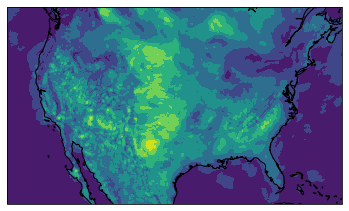

In [48]:
ax = plt.axes(projection=projection)
ax.contourf(std_dev.x, std_dev.y, std_dev)
ax.coastlines()

plt.show()

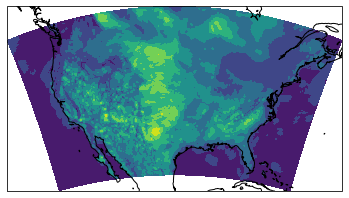

In [49]:
ax = plt.axes(projection=ccrs.Mercator())
ax.contourf(std_dev.x, std_dev.y, std_dev, transform=projection)
ax.coastlines()

plt.show()

### Accelerated Data Analysis with Dask

In this example, the "win" of cloud computing isn't anything to do with performing calculations across large data. Instead, we run a calculation across small data (2,880 hours) a number of times (there are almost 2 million grid points). I/O takes much more time than computation, so beefier machines don't help––what does help is having a lot of separate machines with their own network bandwidth. The fact that we're I/O bound and don't require many compute resources (CPU or memory) means we can request many small, cheap machines to work in parallel.

We create a Dask cluster with a large number of worker nodes managed by 1 central scheduler node that will divvy up tasks and collect the computation results.

This is called an "ephemeral cluster", created to perform just one job and then disappear. It's an approach that allows us to perform the analyses we need when we need them without having to purchase physical machines, handle scheduling machine use with colleagues, or pay for cloud resources that are running idle.

#### Worker code
Every worker will run the same code in parallel. For this example, we'll be writing low-level code to grab each chunk of the zarr array and hand it to a separate worker.

We should be able to use libraries for this––`dask`, `zarr`, and `xarray` all have built-in support for parallelizing computations over chunks.

In [40]:
# Code for low-level access to chunk data (could be simplified for this specific use case)
s3 = s3fs.S3FileSystem(anon=True)

@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        return f"0.{chunk_id}" if self.model_type == "fcst" else chunk_id
        

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = zarr_id.run_hour.strftime(
        f"hrrrzarr/{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}/{zarr_id.var_level}/{zarr_id.var_name}/"
    url += f"{zarr_id.format_chunk_id(chunk_id)}"
    return url


def retrieve_data(zarr_id, s3_url):
    with s3.open(s3_url, 'rb') as compressed_data:
        buffer = ncd.blosc.decompress(compressed_data.read())

        dtype = "<f2"
        if zarr_id.var_level == "surface" and zarr_id.var_name == "PRES":
            dtype = "<f4"

        chunk = np.frombuffer(buffer, dtype=dtype)

        if zarr_id.model_type == "anl":
            data_array = np.reshape(chunk, (150, 150))
        else:
            entry_size = 22500
            data_array = np.reshape(chunk, (len(chunk)//entry_size, 150, 150))

    return data_array


def get_chunk(zid, chunk_id):
    try:
        return retrieve_data(zid, create_s3_chunk_url(zid, chunk_id))
    except:
        return None

In [41]:
# The actual calculation for getting 95 percentile data.
def get_percentile_for_chunk(chunk_id):
    gust_array = np.array([x for x in (get_chunk(zid, chunk_id) for zid in zids) if x is not None])
    percentile_95 = np.percentile(gust_array, 95, axis=0)
    return percentile_95

In [42]:
## Define the data we want to retrieve
from pandas import date_range

dates = []
for year in range(2018, 2020): 
    dates += [hour.to_pydatetime() for hour in date_range(start=f"{year}-09-01",end=f"{year}-10-01",
                                                 freq="H", closed="left")]

zids = [ZarrId(
                run_hour=date,
                level_type="sfc",
                var_level="surface",
                var_name="GUST",
                model_type="anl"
            ) 
        for date in dates]

#### Setting up the cluster
Using dask_cloudprovider, starting the cluster is one line of code. Note that I added some extra stuff to make it easy to find the logs on CloudWatch.

It takes 2-3 minutes to start up for me. You'll start owing Amazon a (small) bill once these resources start up, but note that they'll automatically get killed if you leave the cluster running idle for too long, reducing the risk to you of accidentally incurring large charges. (You should still check manually though and kill any resources left running.) The downside is that it's quite possible for the cluster to time out while you're trying to do interactive data analysis (or debug your code). You can pass the scheduler_timeout argument to mitigate this.



In [43]:
import fsspec
import dask
from dask.distributed import performance_report
from dask.distributed import Client
from dask_gateway import GatewayCluster, Gateway
import boto3
import botocore
from botocore import UNSIGNED
from botocore.client import Config

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [44]:
# Setup a Cluster, Takes ~3min
cluster = GatewayCluster()

# Scale out to 20x Fargate workers with 2 cores and 8GB of RAM. 
# Takes ~3-5 min for resource allocating
cluster.scale(20)
client = cluster.get_client()
cluster

#### Cluster dashboard
The displayed link will show you where the workers are in completing the required computations. It also has a tab showing each node's use of resources, so you can make sure to request machines with the minimum possible resources to minimize your costs.

#### Running the job
We use the dask library to set up a "delayed" object with the instructions for calculating the desired percentile for every chunk. Calling compute() then launches the actual calculation.

Note on runtime and resources
The job will take about 5-6 minutes. It could theoretically be halved by using 96 machines instead of 48, without appreciably increasing the cost (which should be under 50 cents).

In [45]:
%%time
from dask import delayed

chunk_y = range(8)
chunk_x = range(12)

chunk_ids = [f"{y}.{x}" for y in chunk_y for x in chunk_x]
gust_climo_data = delayed(np.array)([
              [delayed(get_percentile_for_chunk)(f"{y}.{x}") for y in chunk_y]
                   for x in chunk_x])
gust_climo_data = gust_climo_data.compute()

CPU times: user 2.98 s, sys: 159 ms, total: 3.14 s
Wall time: 8min 59s


In [46]:
cluster.shutdown()

#### Post-processing the data
Now that we have a small-enough dataset returned to a single machine, we can finish our analysis without using cloud resources.

We knit the chunk data into a single array, then get the latitude/longitude values so we can plot it.

In [47]:
%%time
gust_climo_data = np.hstack(
    [np.vstack(chunk_data) for chunk_data in gust_climo_data])

CPU times: user 9.99 ms, sys: 2.52 ms, total: 12.5 ms
Wall time: 15.8 ms


In [48]:
%%time
# Get lats and lons from chunk index
import xarray as xr

chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=s3))

CPU times: user 25.9 ms, sys: 293 µs, total: 26.2 ms
Wall time: 537 ms


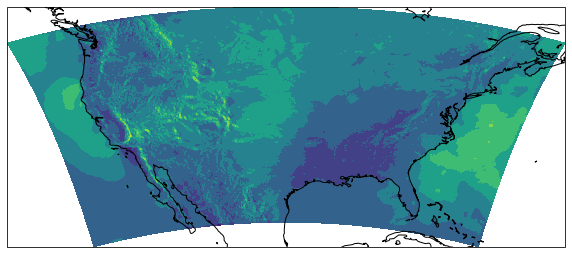

CPU times: user 3.44 s, sys: 461 ms, total: 3.9 s
Wall time: 18.7 s


In [49]:
%%time

# Get rid of invalid values from dummy gridpoints in chunks that weren't actually 150x150
matrix = gust_climo_data[:1059, :1799]
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(chunk_index.longitude, chunk_index.latitude, matrix)
ax.coastlines()
plt.show()
plt.close()